Early stopping of model simulations
===================

For certain distance functions and certain models it is possible to calculate the
distance on-the-fly while the model is running. This is e.g. possible if the distance is calculated as a cumulative sum and the model is a stochastic process. For example, Markov Jump Processes belong to this class. However, we want to keep things simple here and only demonstrate how to use the pyABC interface in such cases. So don't expect a sophisticated (or even useful) model implementation here.

In this example we'll use in particular the following classes for integrated simulation and accepting/rejecting a parameter:

Let's start with the necessary imports:

In [1]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   IntegratedModel, ModelResult,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.sampler import SingleCoreSampler
import matplotlib.pyplot as plt
import os
import tempfile
import pandas as pd
import scipy as sp


db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

We define here a (very) simple stochastic process, purely for demonstrative reasons.
First, we fix the number of steps *n_steps* to 30.

In [2]:
n_steps = 30

We then define our process as follows:

$$
   x(t+1) = x(t) + s \xi,
$$

in which $\xi \sim U(0, 1)$ denotes a uniformly in $[0, 1]$ distributed
random variable, and $s$ is the step size, $s = $ step_size.

The function `simulate` implements this stochastic process:

In [3]:
def simulate(step_size):
    trajectory = sp.zeros(n_steps)
    for t in range(1, n_steps):
        xi = sp.rand()
        trajectory[t] = trajectory[t-1] + xi * step_size
    return trajectory

We take as distance function between two such generated trajectories
the sum of the absolute values of the pointwise differences.

In [4]:
def distance(trajectory_1, trajectory_2):
    return sp.absolute(trajectory_1 - trajectory_2).sum()

Let's run the simulation and plot the trajectories to get a better
idea of the so generated data.
We set the ground truth step size *gt_step_size* to 

In [5]:
gt_step_size = 5

This will be used to generate the data which will be subject to inference later on.

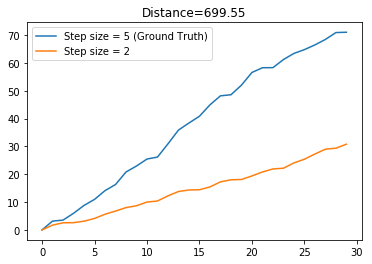

In [6]:
gt_trajectory = simulate(gt_step_size)
trajectoy_2 = simulate(2)

dist_1_2 = distance(gt_trajectory, trajectoy_2)

plt.plot(gt_trajectory,
    label="Step size = {} (Ground Truth)".format(gt_step_size))
plt.plot(trajectoy_2,
    label="Step size = 2")
plt.legend();
plt.title("Distance={:.2f}".format(dist_1_2));

As you might have noted already we could calculate the distance on the fly.
After each step in the stochastic process, we could increment the cumulative sum.
This will supposedly save time in the ABC-SMC run later on.

Let's start with the code first and explain it afterwards.

In [7]:
class MyStochasticProcess(IntegratedModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_early_stopped = 0
    
    def integrated_simulate(self, pars, eps):
        cumsum = 0
        trajectory = sp.zeros(n_steps)
        for t in range(1, n_steps):
            xi = sp.rand()
            next_val = trajectory[t-1] + xi * pars["step_size"]
            cumsum += abs(next_val - gt_trajectory[t])
            trajectory[t] = next_val
            if cumsum > eps:
                self.n_early_stopped += 1
                return ModelResult(accepted=False)
            
        return ModelResult(accepted=True,
                           distance=cumsum,
                           sum_stats={"trajectory": trajectory})

Our `MyStochasticProcess` class is a subclass of `IntegratedModel <pyabc.model.IntegratedModel>`.

The `__init__` method is not really necessary. Here, we just want to keep
track of how often early stopping has actually happened.

More interesting is the `integrated_simulate` method. This is where the real thing
happens.
As already said, we calculate the cumulative sum on the fly.
In each simulation step, we update the cumulative sum.
Note that *gt_trajectory* is actually a global variable here.
If *cumsum > eps* at some step of the simulation, we return immediately,
indicating that the parameter was not accepted
by returning `ModelResult(accepted=False)`.
If the *cumsum* never passed *eps*, the parameter got accepted. In this case
we return an accepted result together with the calculated distance and the trajectory.
Note that, while it is mandatory to return the distance, returning the trajectory is optional. If it is returned, it is stored in the database.

We define a uniform prior over the interval $[0, 10]$ over the step size

In [8]:
prior = Distribution(step_size=RV("uniform", 0 , 10))

and create and instance of our integrated model MyStochasticProcess

In [9]:
model = MyStochasticProcess()

We then configure the ABC-SMC run.
As the distance function is calculated within `MyStochasticProcess`, we just pass
`None` to the `distance_function` parameter. 
As sampler, we use the `SingleCoreSampler` here. We do so to correctly keep track of `MyStochasticProcess.n_early_stopped`. Otherwise, the counter gets incremented in subprocesses and we don't see anything here.
Of course, you could also use the `MyStochasticProcess` model in a multi-core or
distributed setting.

Importantly, we pre-specify the initial acceptance threshold to a given value, here to 300. Otherwise, pyABC will try to automatically determine it by drawing samples from the prior and evaluating the distance function.
However, we do not have a distance function here, so this approach would break down.

In [10]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=None,
             sampler=SingleCoreSampler(),
             population_size=30,
             transitions=LocalTransition(k_fraction=.2),
             eps=MedianEpsilon(300, median_multiplier=0.7))

We then indicate that we want to start a new ABC-SMC run:

In [11]:
abc.new(db_path)

INFO:Epsilon:initial epsilon is 300
INFO:History:Start <ABCSMC(id=3, start_time=2018-04-09 11:46:03.313693, end_time=None)>


3

We do not need to pass any data here. However, we could still pass additionally
a dictionary `{"trajectory": gt_trajectory}` only for storage purposes
to the `new` method. The data will however be ignored during the ABC-SMC run.

Then, let's start the sampling

In [12]:
h = abc.run(minimum_epsilon=40, max_nr_populations=3)

INFO:ABC:t:0 eps:300
INFO:ABC:t:1 eps:117.06141309950016
INFO:ABC:t:2 eps:63.696183308934806
INFO:History:Done <ABCSMC(id=3, start_time=2018-04-09 11:46:03.313693, end_time=2018-04-09 11:46:09.333116)>


and check how often the early stopping was used:

In [13]:
model.n_early_stopped

1069

Quite a lot actually.

Lastly we estimate KDEs of the different populations to inspect our results
and plot everything (the vertical dashed line is the ground truth step size).

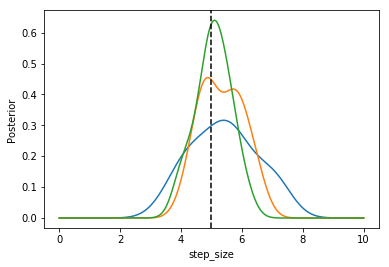

In [14]:
from pyabc.visualization import plot_kde_1d
fig, ax = plt.subplots()

for t in range(h.max_t+1):
    particles = h.get_distribution(m=0, t=t)
    plot_kde_1d(*particles, "step_size",
                label="t={}".format(t), ax=ax,
                xmin=0, xmax=10, numx=300)
ax.axvline(gt_step_size, color="k", linestyle="dashed");    

That's it. You should be able to see how the distribution
contracts around the true parameter.